# H&M Fashion search engine with Weaviate and DocArray

In this notebook, we use [DocArray](https://docarray.jina.ai/) and with the vector DB [Weaviate](https://weaviate.io/) to show how you can set up a simple similar image search. 

If you have questions or let us know your feedback, please join the [Weaviate Slack channel](https://join.slack.com/t/weaviate/shared_invite/zt-goaoifjr-o8FuVz9b1HLzhlUfyfddhw)!

## 0. Install libraries

In [5]:
!pip install docarray[full]
!pip install torchvision==0.11.2

## 1. Importing libraries

In [6]:
from docarray import Document, DocumentArray

## 2. Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

There is some sample data included in this repository. If you want to use the demo with the full H&M Fashion image dataset, follow the steps in the Readme to download the images from the [Kaggle competition](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/data).

The images in the sample dataset are already scaled down to 80x60 to limit the file size.

In [7]:
MAX_DOCS = 100
DATA_DIR = 'sample_data'
DATA_PATH = f"{DATA_DIR}/**/*.jpg"
QUERY_IMAGE =  "sample_data/012/0120129025.jpg"

Now we initiate the vector storage of the images, using Weaviate. You need to have a Weaviate instance running on `http://localhost:8080`. You can do that by running `docker compose up` in the terminal in this folder, using the `docker-compose.yml` file. 
Alternatively, you can start a Weaviate instance for free with [WCS: Weaviate Cloud Service](https://console.semi.technology/). 

DocArray supports Weaviate as a storage backend, one can use it as the follows:

In [8]:
DocumentArray(storage='weaviate', config={'host': 'localhost', 'port': 8080, 'name': 'Image'}).summary()

╭─────────────── Documents Summary ────────────────╮
│                                                  │
│   Type                   DocumentArrayWeaviate   │
│   Length                 0                       │
│   Homogenous Documents   False                   │
│   Multimodal dataclass   True                    │
│                                                  │
╰──────────────────────────────────────────────────╯
╭────── DocumentArrayWeaviate Config ──────╮
│                                          │
│   host                       localhost   │
│   port                       8080        │
│   protocol                   http        │
│   name                       Image       │
│   serialize_config           {}          │
│   n_dim                      None        │
│   ef                         None        │
│   ef_construction            None        │
│   timeout_config             None        │
│   max_connections            None        │
│   dynamic_ef_min             None        │
│   dynamic_ef_max             None        │
│   dynamic_ef_factor          None        │
│   vector_cache_max_objects   None        │
│   flat_search_cutoff         None        │
│   cleanup_interval_seconds   None        │
│   skip                       None        │
│   columns                    {}          │
│   distance                   None        │
│                                          │
╰──────────────────────────────────────────╯

The look-and-feel of a weaviate-powered DocumentArray is exactly the same as an ordinary DocumentArray. All APIs behave the same. We will see that in the sequel.

## 3. Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [9]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'Image'})

print(f"{len(docs)} Documents in DocumentArray")
type(docs)


100 Documents in DocumentArray


docarray.array.weaviate.DocumentArrayWeaviate

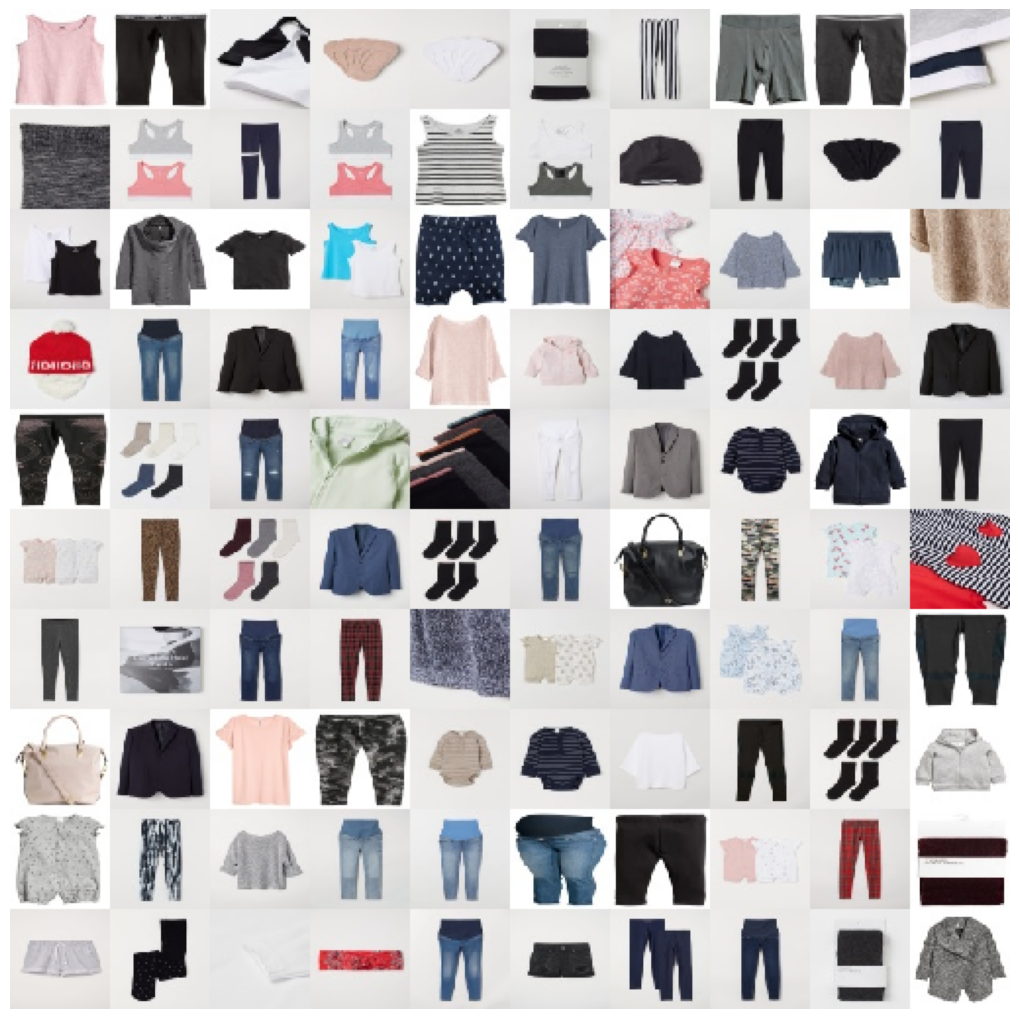

In [10]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [11]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [12]:
# apply en masse
docs.apply(preproc)

╭─────────────────────── Documents Summary ───────────────────────╮
│                                                                 │
│   Type                   DocumentArrayWeaviate                  │
│   Length                 100                                    │
│   Homogenous Documents   True                                   │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri')   │
│   Multimodal dataclass   False                                  │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   id          ('str',)       100              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   100              False             │
│   uri         ('str',)       100              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────── DocumentArrayWeaviate Config ──────╮
│                                          │
│   host                       localhost   │
│   port                       8080        │
│   protocol                   http        │
│   name                       Image       │
│   serialize_config           {}          │
│   n_dim                      None        │
│   ef                         None        │
│   ef_construction            None        │
│   timeout_config             None        │
│   max_connections            None        │
│   dynamic_ef_min             None        │
│   dynamic_ef_max             None        │
│   dynamic_ef_factor          None        │
│   vector_cache_max_objects   None        │
│   flat_search_cutoff         None        │
│   cleanup_interval_seconds   None        │
│   skip                       None        │
│   columns                    {}          │
│   distance                   None        │
│                                          │
╰──────────────────────────────────────────╯

## 5. Embed images

Using GPU is recommended when you want to do image search on large scale. 

In [13]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

/home/sai.s.kamat/semi-tech-assignment/task_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use the ResNet50 model to embed our images. 

In [14]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [15]:
docs.embed(model, device=device, batch_size=340)

╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Type                   DocumentArrayWeaviate                               │
│   Length                 100                                                 │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    100              False             │
│   id          ('str',)       100              False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   100              False             │
│   uri         ('str',)       100              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────── DocumentArrayWeaviate Config ──────╮
│                                          │
│   host                       localhost   │
│   port                       8080        │
│   protocol                   http        │
│   name                       Image       │
│   serialize_config           {}          │
│   n_dim                      None        │
│   ef                         None        │
│   ef_construction            None        │
│   timeout_config             None        │
│   max_connections            None        │
│   dynamic_ef_min             None        │
│   dynamic_ef_max             None        │
│   dynamic_ef_factor          None        │
│   vector_cache_max_objects   None        │
│   flat_search_cutoff         None        │
│   cleanup_interval_seconds   None        │
│   skip                       None        │
│   columns                    {}          │
│   distance                   None        │
│                                          │
╰──────────────────────────────────────────╯

We can remove the tensor of the images to reduce remory usage. This will significantly improve the speed of the `.find()` operation below.

In [16]:
docs[:, 'tensor'] = None

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

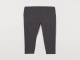

In [17]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [18]:
query_doc = preproc(query_doc)

In [19]:
query_doc.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

📄 Document: edf73594549975617c6b25323044e22a
╭────────────┬─────────────────────────────────────────────────────────────────╮
│ Attribute  │ Value                                                           │
├────────────┼─────────────────────────────────────────────────────────────────┤
│ tensor     │ <class 'numpy.ndarray'> in shape (3, 80, 60), dtype: float32    │
│ mime_type  │ image/jpeg                                                      │
│ uri        │ sample_data/012/0120129025.jpg                                  │
│ embedding  │ <class 'torch.Tensor'> in shape (1000,), dtype: float32         │
╰────────────┴─────────────────────────────────────────────────────────────────╯

In [ ]:
# top10 = docs.find(query_doc, limit=10)
# len(top10)
# type(top10[0])

# AND THIS
Show the result:

In [ ]:
# top10[0].plot_image_sprites(image_source='uri')

That's it! You can change the example query image and try out more searches yourself.

## Using match() instead

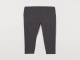

📄 Document: 7308fda95a36c1204622db3ff077462e
╭────────────┬─────────────────────────────────────────────────────────────────╮
│ Attribute  │ Value                                                           │
├────────────┼─────────────────────────────────────────────────────────────────┤
│ tensor     │ <class 'numpy.ndarray'> in shape (3, 80, 60), dtype: float32    │
│ mime_type  │ image/jpeg                                                      │
│ uri        │ sample_data/012/0120129025.jpg                                  │
│ embedding  │ <class 'torch.Tensor'> in shape (1000,), dtype: float32         │
╰────────────┴─────────────────────────────────────────────────────────────────╯

In [21]:
# top10 = docs.find(query_doc, limit=10)
QUERY_IMAGE2 =  "sample_data/012/0120129025.jpg"
query_doc2 = Document(uri=QUERY_IMAGE2)
query_doc2.display()

query_doc2 = preproc(query_doc2)
query_doc2.embed(model, device=device)


In [22]:
match_response = query_doc2.match(docs)
match_response.summary()

📄 Document: 7308fda95a36c1204622db3ff077462e
╭────────────┬─────────────────────────────────────────────────────────────────╮
│ Attribute  │ Value                                                           │
├────────────┼─────────────────────────────────────────────────────────────────┤
│ tensor     │ <class 'numpy.ndarray'> in shape (3, 80, 60), dtype: float32    │
│ mime_type  │ image/jpeg                                                      │
│ uri        │ sample_data/012/0120129025.jpg                                  │
│ embedding  │ <class 'torch.Tensor'> in shape (1000,), dtype: float32         │
╰────────────┴─────────────────────────────────────────────────────────────────╯
└── 🔶 Matches
    ├── 📄 Document: 2cb3a9f102d3b3db269ae0fc8e650e3b
    │   ╭───────────┬──────────────────────────────────────────────────────────────────╮
    │   │ Attribute │ Value                                                            │
    │   ├───────────┼──────────────────────────────────────────────────────────────────┤
    │   │ adjacency │ 1                                                                │
    │   │ mime_type │ image/jpeg                                                       │
    │   │ uri       │ sample_data/019/0198714006.jpg                                   │
    │   │ tags      │ {'wid': 'e6fa7aad-0661-5a67-84eb-a33c49f0df89'}                  │
    │   │ embedding │ <class 'torch.Tensor'> in shape (1000,), dtype: float32          │
    │   │ scores    │ defaultdict(<class 'docarray.score.NamedScore'>,                 │
    │   │           │ {'weaviate_certainty': {'value': 0.96601206},                    │
    │   │           │ 'cosine_similarity': {'value': 0.9320241199999999}})             │
    │   ╰───────────┴──────────────────────────────────────────────────────────────────╯
    ├── 📄 Document: 9ad9ab83ac96bc26e67c5997deb1547d
    │   ╭───────────┬──────────────────────────────────────────────────────────────────╮
    │   │ Attribute │ Value                                                            │
    │   ├───────────┼──────────────────────────────────────────────────────────────────┤
    │   │ adjacency │ 1                                                                │
    │   │ mime_type │ image/jpeg                                                       │
    │   │ uri       │ sample_data/024/0243613004.jpg                                   │
    │   │ tags      │ {'wid': 'c0248e3c-b962-518d-a783-f6c3a3c25dc7'}                  │
    │   │ embedding │ <class 'torch.Tensor'> in shape (1000,), dtype: float32          │
    │   │ scores    │ defaultdict(<class 'docarray.score.NamedScore'>,                 │
    │   │           │ {'weaviate_certainty': {'value': 0.96484375},                    │
    │   │           │ 'cosine_similarity': {'value': 0.9296875}})                      │
    │   ╰───────────┴──────────────────────────────────────────────────────────────────╯
    ├── 📄 Document: 36ce7f674c90e11c2638c4a7b87ca856
    │   ╭───────────┬──────────────────────────────────────────────────────────────────╮
    │   │ Attribute │ Value                                                            │
    │   ├───────────┼──────────────────────────────────────────────────────────────────┤
    │   │ adjacency │ 1                                                                │
    │   │ mime_type │ image/jpeg                                                       │
    │   │ uri       │ sample_data/024/0241412052.jpg                                   │
    │   │ tags      │ {'wid': 'e0e3f392-75e6-5cbf-a9f8-090b2b771166'}                  │
    │   │ embedding │ <class 'torch.Tensor'> in shape (1000,), dtype: float32          │
    │   │ scores    │ defaultdict(<class 'docarray.score.NamedScore'>,                 │
    │   │           │ {'weaviate_certainty': {'value': 0.9433807},                     │
    │   │           │ 'cosine_similarity': {'value': 0.8867613999999999}})             │
    │   ╰──────────

In [38]:
match_doc = DocumentArray(match_response)
match_doc

╭──────────────────────────────────── Documents Summary ─────────────────────────────────────╮
│                                                                                            │
│   Type                      DocumentArrayInMemory                                          │
│   Length                    1                                                              │
│   Homogenous Documents      True                                                           │
│   Has nested Documents in   ('matches',)                                                   │
│   Common Attributes         ('id', 'tensor', 'mime_type', 'uri', 'embedding', 'matches')   │
│   Multimodal dataclass      False                                                          │
│                                                                                            │
╰────────────────────────────────────────────────────────────────────────────────────────────╯
╭──────────────────────── Attributes Summary ────────────────────────╮
│                                                                    │
│   Attribute   Data type         #Unique values   Has empty value   │
│  ────────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)       1                False             │
│   id          ('str',)          1                False             │
│   matches     ('MatchArray',)   1                False             │
│   mime_type   ('str',)          1                False             │
│   tensor      ('ndarray',)      1                False             │
│   uri         ('str',)          1                False             │
│                                                                    │
╰────────────────────────────────────────────────────────────────────╯

In [42]:
match_doc

<bound method ContentPropertyMixin._check_length of <DocumentArray (length=1) at 139899868518384>>